In [1]:
import pandas as pd
import numpy as np

revlogs = pd.read_csv("./Repetition History-Leee-2023-08-09.csv")
print(revlogs.shape)
print(revlogs['ElNo'].unique().shape)
revlogs.head()

(63191, 11)
(13684,)


,Date,Difficulty,ElNo,Grade,Hour,Int,Laps,Postpones,Priority,Rep,expFI
0,2022-04-22,NaN,6,8,8.187,0,0,NaN,0.2998,1,99.0
1,2022-04-23,0.000,6,4,7.869,1,0,NaN,0.2954,2,14.0
2,2022-04-25,0.705,6,4,12.311,2,0,NaN,5.1183,3,1.0
3,2022-05-23,0.668,6,3,8.816,28,0,NaN,5.3459,4,7.0
4,2022-12-29,1.000,6,1,15.371,220,1,NaN,1.2276,1,9.0


In [2]:
revlogs.drop(["Difficulty", "Hour", "Postpones", "Priority"], axis=1, inplace=True, errors="ignore")
revlogs.head()

,Date,ElNo,Grade,Int,Laps,Rep,expFI
0,2022-04-22,6,8,0,0,1,99.0
1,2022-04-23,6,4,1,0,2,14.0
2,2022-04-25,6,4,2,0,3,1.0
3,2022-05-23,6,3,28,0,4,7.0
4,2022-12-29,6,1,220,1,1,9.0


In [3]:
revlogs = revlogs.groupby('ElNo').filter(lambda group: (group['Rep'].iloc[0] == 1) and (group['Laps'].iloc[0] == 0))
print(revlogs.shape)
revlogs.head()

(62239, 7)


,Date,ElNo,Grade,Int,Laps,Rep,expFI
0,2022-04-22,6,8,0,0,1,99.0
1,2022-04-23,6,4,1,0,2,14.0
2,2022-04-25,6,4,2,0,3,1.0
3,2022-05-23,6,3,28,0,4,7.0
4,2022-12-29,6,1,220,1,1,9.0


In [4]:
revlogs.drop(revlogs[revlogs['expFI'] == 99].index, inplace=True)
print(revlogs.shape)
revlogs.head()

(47977, 7)


,Date,ElNo,Grade,Int,Laps,Rep,expFI
1,2022-04-23,6,4,1,0,2,14.0
2,2022-04-25,6,4,2,0,3,1.0
3,2022-05-23,6,3,28,0,4,7.0
4,2022-12-29,6,1,220,1,1,9.0
5,2022-12-30,6,4,1,1,2,8.0


In [5]:
revlogs = revlogs.groupby('ElNo').filter(lambda group: (group['Grade'] > 5).sum() == 0)
print(revlogs.shape)
revlogs.head()

(40820, 7)


,Date,ElNo,Grade,Int,Laps,Rep,expFI
1,2022-04-23,6,4,1,0,2,14.0
2,2022-04-25,6,4,2,0,3,1.0
3,2022-05-23,6,3,28,0,4,7.0
4,2022-12-29,6,1,220,1,1,9.0
5,2022-12-30,6,4,1,1,2,8.0


In [6]:
revlogs.drop_duplicates(subset=['Date', 'ElNo'], keep='first', inplace=True)
print(revlogs.shape)
revlogs.head()

(40819, 7)


,Date,ElNo,Grade,Int,Laps,Rep,expFI
1,2022-04-23,6,4,1,0,2,14.0
2,2022-04-25,6,4,2,0,3,1.0
3,2022-05-23,6,3,28,0,4,7.0
4,2022-12-29,6,1,220,1,1,9.0
5,2022-12-30,6,4,1,1,2,8.0


In [7]:
revlogs['i'] = revlogs.groupby('ElNo').cumcount() + 1
revlogs.head()

,Date,ElNo,Grade,Int,Laps,Rep,expFI,i
1,2022-04-23,6,4,1,0,2,14.0,1
2,2022-04-25,6,4,2,0,3,1.0,2
3,2022-05-23,6,3,28,0,4,7.0,3
4,2022-12-29,6,1,220,1,1,9.0,4
5,2022-12-30,6,4,1,1,2,8.0,5


In [8]:
revlogs['Date'] = pd.to_datetime(revlogs['Date'])
revlogs['delta_t'] = revlogs['Date'].diff().dt.days
revlogs['delta_t'] = revlogs['delta_t'].fillna(0)
revlogs.loc[revlogs['i'] == 1, 'delta_t'] = 0
revlogs['delta_t'] = revlogs['delta_t'].astype(int)
revlogs.head()

,Date,ElNo,Grade,Int,Laps,Rep,expFI,i,delta_t
1,2022-04-23,6,4,1,0,2,14.0,1,0
2,2022-04-25,6,4,2,0,3,1.0,2,2
3,2022-05-23,6,3,28,0,4,7.0,3,28
4,2022-12-29,6,1,220,1,1,9.0,4,220
5,2022-12-30,6,4,1,1,2,8.0,5,1


In [9]:
revlogs.rename(columns={'ElNo': 'card_id', 'Date': 'review_date'}, inplace=True)
revlogs['review_rating'] = revlogs['Grade'].map({1: 1, 2: 1, 3: 2, 4: 3, 5: 4})
revlogs['review_time'] = 0
revlogs.head()

,review_date,card_id,Grade,Int,Laps,Rep,expFI,i,delta_t,review_rating,review_time
1,2022-04-23,6,4,1,0,2,14.0,1,0,3,0
2,2022-04-25,6,4,2,0,3,1.0,2,2,3,0
3,2022-05-23,6,3,28,0,4,7.0,3,28,2,0
4,2022-12-29,6,1,220,1,1,9.0,4,220,1,0
5,2022-12-30,6,4,1,1,2,8.0,5,1,3,0


In [10]:
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))

t_history = revlogs.groupby('card_id', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
revlogs['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = revlogs.groupby('card_id', group_keys=False)['review_rating'].apply(lambda x: cum_concat([[i] for i in x]))
revlogs['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
revlogs.head()

,review_date,card_id,Grade,Int,Laps,Rep,expFI,i,delta_t,review_rating,review_time,t_history,r_history
1,2022-04-23,6,4,1,0,2,14.0,1,0,3,0,,
2,2022-04-25,6,4,2,0,3,1.0,2,2,3,0,0,3
3,2022-05-23,6,3,28,0,4,7.0,3,28,2,0,"0,2","3,3"
4,2022-12-29,6,1,220,1,1,9.0,4,220,1,0,"0,2,28","3,3,2"
5,2022-12-30,6,4,1,1,2,8.0,5,1,3,0,"0,2,28,220","3,3,2,1"


In [11]:
revlogs['y'] = revlogs['review_rating'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])

def remove_outliers(group: pd.DataFrame) -> pd.DataFrame:
    # threshold = np.mean(group['delta_t']) * 1.5
    # threshold = group['delta_t'].quantile(0.95)
    Q1 = group['delta_t'].quantile(0.25)
    Q3 = group['delta_t'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    group = group[group['delta_t'] <= threshold]
    return group

revlogs[revlogs['i'] == 2] = revlogs[revlogs['i'] == 2].groupby(by=['r_history', 't_history'], as_index=False, group_keys=False).apply(remove_outliers)
revlogs.dropna(inplace=True)
print(revlogs.shape)

def remove_non_continuous_rows(group):
    discontinuity = group['i'].diff().fillna(1).ne(1)
    if not discontinuity.any():
        return group
    else:
        first_non_continuous_index = discontinuity.idxmax()
        return group.loc[:first_non_continuous_index-1]

revlogs = revlogs.groupby('card_id', as_index=False, group_keys=False).apply(remove_non_continuous_rows)
print(revlogs.shape)
revlogs.head()

(39423, 14)
(37564, 14)


,review_date,card_id,Grade,Int,Laps,Rep,expFI,i,delta_t,review_rating,review_time,t_history,r_history,y
1,2022-04-23,6.0,4.0,1.0,0.0,2.0,14.0,1.0,0.0,3.0,0.0,,,1.0
2,2022-04-25,6.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,3.0,0.0,0,3,1.0
3,2022-05-23,6.0,3.0,28.0,0.0,4.0,7.0,3.0,28.0,2.0,0.0,"0,2","3,3",1.0
4,2022-12-29,6.0,1.0,220.0,1.0,1.0,9.0,4.0,220.0,1.0,0.0,"0,2,28","3,3,2",0.0
5,2022-12-30,6.0,4.0,1.0,1.0,2.0,8.0,5.0,1.0,3.0,0.0,"0,2,28,220","3,3,2,1",1.0


In [12]:
revlogs.to_csv('revlog_history.tsv', sep="\t", index=False)

{1: 0.7764575058192442}
{1: 0.7764575058192442, 2: 13.003862942084991}
{1: 0.7764575058192442, 2: 13.003862942084991, 3: 49.245461856423574}
{1: 0.7764575058192442, 2: 13.003862942084991, 3: 49.245461856423574, 4: 108.40445778271327}
Pretrain finished!


[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

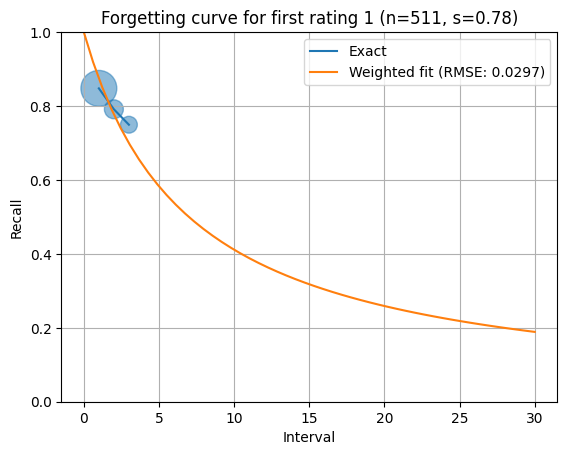

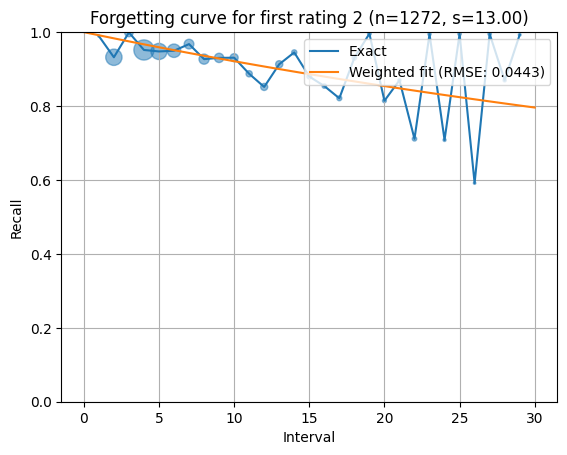

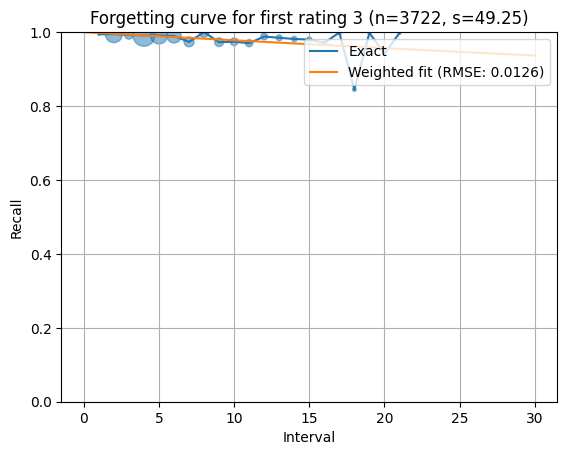

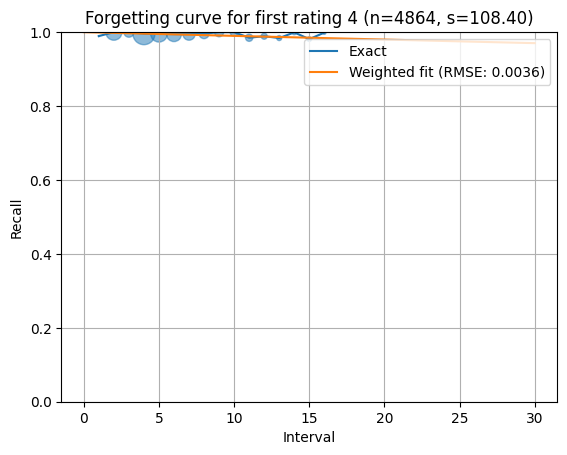

In [13]:
import fsrs_optimizer

optimizer = fsrs_optimizer.Optimizer()

S0_dataset = revlogs[revlogs['i'] == 2]
optimizer.S0_dataset_group = S0_dataset.groupby(by=['r_history', 'delta_t'], group_keys=False).agg({'y': ['mean', 'count']}).reset_index()

optimizer.define_model()
optimizer.pretrain(verbose=True)

  0%|          | 0/25243 [00:00<?, ?it/s]

Tensorized!
TRAIN: 17414 TEST: 7829
dataset built


train:   0%|          | 0/59545 [00:00<?, ?it/s]

iteration: 6144
w: [0.78, 13.0, 49.25, 108.4, 4.6136, 0.7053, 0.6178, 0.254, 1.8389, 0.1, 1.2787, 2.347, 0.01, 0.5051, 1.4287, 0.5713, 2.7668]
iteration: 12288
w: [0.78, 13.0, 49.25, 108.4, 4.5455, 0.6757, 0.5923, 0.2754, 1.9214, 0.1381, 1.3653, 2.2842, 0.0632, 0.4019, 1.4045, 0.5913, 2.8059]
iteration: 18053
w: [0.78, 13.0, 49.25, 108.4, 4.5395, 0.696, 0.626, 0.2394, 1.9375, 0.1319, 1.3843, 2.2519, 0.0903, 0.3439, 1.3866, 0.5211, 2.8146]
iteration: 24197
w: [0.78, 13.0, 49.25, 108.4, 4.5899, 0.7518, 0.6697, 0.1712, 1.8878, 0.1915, 1.342, 2.2972, 0.0472, 0.3662, 1.4207, 0.4471, 2.7723]
iteration: 29962
w: [0.78, 13.0, 49.25, 108.4, 4.5721, 0.7792, 0.6583, 0.1497, 1.9113, 0.1796, 1.3631, 2.3037, 0.0405, 0.3355, 1.4319, 0.4871, 2.7585]
iteration: 36106
w: [0.78, 13.0, 49.25, 108.4, 4.5602, 0.8158, 0.6522, 0.1237, 1.9306, 0.1703, 1.3802, 2.3201, 0.0225, 0.3366, 1.4491, 0.4909, 2.7582]
iteration: 41871
w: [0.78, 13.0, 49.25, 108.4, 4.5585, 0.8514, 0.6573, 0.0986, 1.9394, 0.1624, 1.3871, 2.

train:   0%|          | 0/59490 [00:00<?, ?it/s]

iteration: 6144
w: [0.78, 13.0, 49.25, 108.4, 4.5853, 0.6535, 0.6131, 0.2584, 1.8735, 0.1, 1.3137, 2.3205, 0.0126, 0.4383, 1.397, 0.6021, 2.8639]
iteration: 12288
w: [0.78, 13.0, 49.25, 108.4, 4.5321, 0.6247, 0.6068, 0.2815, 1.9426, 0.1453, 1.388, 2.2733, 0.0566, 0.3719, 1.3324, 0.5623, 3.0599]
iteration: 18042
w: [0.78, 13.0, 49.25, 108.4, 4.5657, 0.6464, 0.6466, 0.2521, 1.9064, 0.1845, 1.3614, 2.2584, 0.0673, 0.3203, 1.3018, 0.4729, 3.0995]
iteration: 24186
w: [0.78, 13.0, 49.25, 108.4, 4.5686, 0.6775, 0.678, 0.219, 1.9134, 0.1891, 1.368, 2.3021, 0.0246, 0.356, 1.3252, 0.4023, 3.1401]
iteration: 29940
w: [0.78, 13.0, 49.25, 108.4, 4.5606, 0.7142, 0.6855, 0.2003, 1.9291, 0.1769, 1.3811, 2.3434, 0.01, 0.385, 1.3667, 0.4042, 3.1476]
iteration: 36084
w: [0.78, 13.0, 49.25, 108.4, 4.5622, 0.7518, 0.7082, 0.169, 1.9373, 0.1687, 1.3869, 2.3375, 0.0296, 0.372, 1.3508, 0.3918, 3.174]
iteration: 41838
w: [0.78, 13.0, 49.25, 108.4, 4.5587, 0.7639, 0.7179, 0.1541, 1.9453, 0.1673, 1.3936, 2.3219,

train:   0%|          | 0/59530 [00:00<?, ?it/s]

iteration: 6144
w: [0.78, 13.0, 49.25, 108.4, 4.5982, 0.6868, 0.6572, 0.2284, 1.8516, 0.1, 1.2975, 2.3277, 0.0112, 0.4746, 1.3672, 0.5378, 2.9596]
iteration: 12288
w: [0.78, 13.0, 49.25, 108.4, 4.5259, 0.6589, 0.6617, 0.2344, 1.9437, 0.1449, 1.3932, 2.268, 0.0651, 0.3935, 1.2947, 0.511, 3.0865]
iteration: 18050
w: [0.78, 13.0, 49.25, 108.4, 4.5268, 0.7219, 0.7092, 0.1919, 1.9596, 0.1211, 1.41, 2.2101, 0.1181, 0.3077, 1.2293, 0.4051, 3.0947]
iteration: 24194
w: [0.78, 13.0, 49.25, 108.4, 4.5633, 0.8274, 0.7461, 0.129, 1.9335, 0.1531, 1.3855, 2.2754, 0.0528, 0.3657, 1.2684, 0.3019, 3.081]
iteration: 29956
w: [0.78, 13.0, 49.25, 108.4, 4.5758, 0.8773, 0.7154, 0.1232, 1.9148, 0.1905, 1.3688, 2.3035, 0.0233, 0.3803, 1.2648, 0.3128, 3.0282]
iteration: 36100
w: [0.78, 13.0, 49.25, 108.4, 4.5307, 0.889, 0.6631, 0.1564, 1.9545, 0.1654, 1.4054, 2.3247, 0.0109, 0.3895, 1.2538, 0.3681, 3.0448]
iteration: 41862
w: [0.78, 13.0, 49.25, 108.4, 4.5202, 0.9091, 0.6479, 0.162, 1.965, 0.1607, 1.4143, 2.33

train:   0%|          | 0/59440 [00:00<?, ?it/s]

iteration: 6144
w: [0.78, 13.0, 49.25, 108.4, 4.5864, 0.6583, 0.6314, 0.2486, 1.856, 0.1, 1.2979, 2.3601, 0.01, 0.5119, 1.419, 0.5706, 2.8847]
iteration: 12288
w: [0.78, 13.0, 49.25, 108.4, 4.5178, 0.6092, 0.6193, 0.2728, 1.9364, 0.1567, 1.3834, 2.3198, 0.0512, 0.4623, 1.3538, 0.5619, 3.0043]
iteration: 18032
w: [0.78, 13.0, 49.25, 108.4, 4.5442, 0.6576, 0.67, 0.2335, 1.9177, 0.1568, 1.3723, 2.2585, 0.1099, 0.3908, 1.2684, 0.4578, 3.0096]
iteration: 24176
w: [0.78, 13.0, 49.25, 108.4, 4.5609, 0.6971, 0.7087, 0.1873, 1.9095, 0.1773, 1.3656, 2.2737, 0.0952, 0.3961, 1.2727, 0.4034, 3.0278]
iteration: 29920
w: [0.78, 13.0, 49.25, 108.4, 4.5644, 0.7052, 0.7072, 0.1741, 1.9035, 0.2074, 1.3608, 2.3075, 0.0645, 0.4197, 1.2653, 0.3926, 3.0051]
iteration: 36064
w: [0.78, 13.0, 49.25, 108.4, 4.5389, 0.7221, 0.7016, 0.1642, 1.9342, 0.1865, 1.3877, 2.3332, 0.04, 0.4393, 1.2595, 0.4165, 3.0226]
iteration: 41808
w: [0.78, 13.0, 49.25, 108.4, 4.5244, 0.7315, 0.7037, 0.1539, 1.953, 0.1751, 1.4042, 2.33

train:   0%|          | 0/59475 [00:00<?, ?it/s]

iteration: 6144
w: [0.78, 13.0, 49.25, 108.4, 4.5508, 0.6294, 0.6191, 0.2543, 1.8782, 0.1, 1.3222, 2.285, 0.0202, 0.4123, 1.3189, 0.6144, 2.9378]
iteration: 12288
w: [0.78, 13.0, 49.25, 108.4, 4.4543, 0.5645, 0.6105, 0.2754, 1.9779, 0.1445, 1.4345, 2.2089, 0.0909, 0.3219, 1.2378, 0.6298, 3.0692]
iteration: 18039
w: [0.78, 13.0, 49.25, 108.4, 4.4593, 0.6022, 0.6555, 0.2398, 1.9814, 0.1463, 1.443, 2.1584, 0.1361, 0.2441, 1.2015, 0.524, 3.0611]
iteration: 24183
w: [0.78, 13.0, 49.25, 108.4, 4.4794, 0.6634, 0.7071, 0.1786, 1.9654, 0.1798, 1.4337, 2.2439, 0.0528, 0.3298, 1.2834, 0.4419, 3.0687]
iteration: 29934
w: [0.78, 13.0, 49.25, 108.4, 4.5066, 0.7239, 0.7268, 0.1359, 1.9401, 0.2167, 1.411, 2.3372, 0.01, 0.4151, 1.3527, 0.4182, 3.0122]
iteration: 36078
w: [0.78, 13.0, 49.25, 108.4, 4.4706, 0.7458, 0.7147, 0.1317, 1.9801, 0.187, 1.4467, 2.3341, 0.0342, 0.4092, 1.332, 0.4495, 3.0344]
iteration: 41829
w: [0.78, 13.0, 49.25, 108.4, 4.4588, 0.7592, 0.7134, 0.1231, 1.9947, 0.1803, 1.4596, 2.2

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

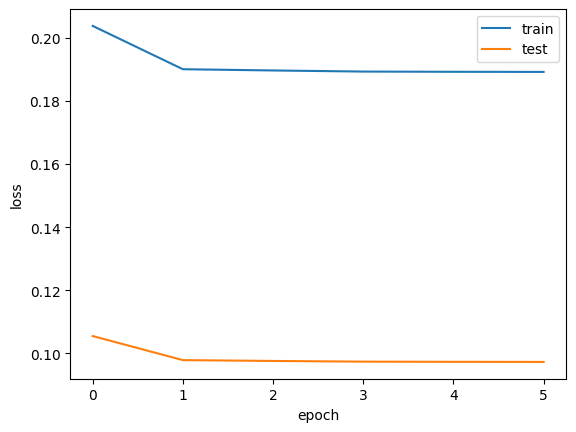

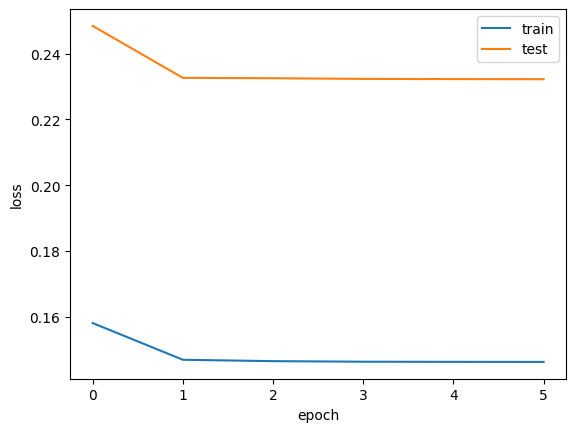

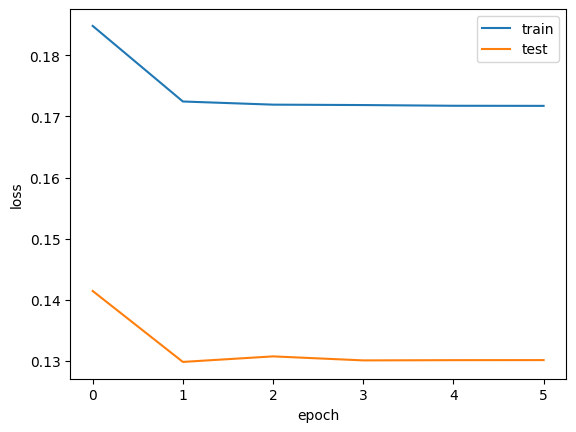

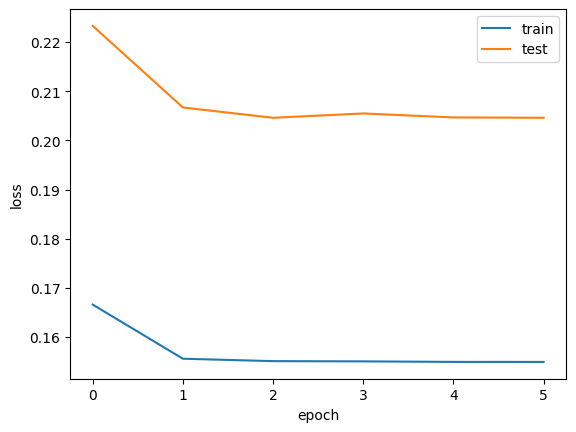

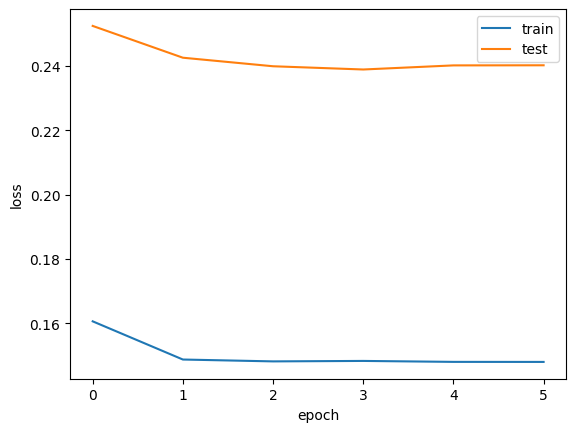

In [14]:
optimizer.train(verbose=True)

In [15]:
print(optimizer.preview(0.9))

1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,1d,6d,1.1m,4.7m,1.4y,4.7y,13.8y,36.6y,88.9y,100.0y
difficulty history: 0,6.2,6.0,5.8,5.6,5.5,5.3,5.2,5.1,5.1,5.0

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,13d,2.2m,9.6m,2.9y,9.1y,25.6y,65.6y,100.0y,100.0y,100.0y
difficulty history: 0,5.4,5.2,5.1,5.1,5.0,4.9,4.9,4.8,4.8,4.8

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,1.6m,7.9m,2.6y,8.7y,25.7y,68.1y,100.0y,100.0y,100.0y,100.0y
difficulty history: 0,4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,3.6m,1.4y,5.4y,17.9y,51.5y,100.0y,100.0y,100.0y,100.0y,100.0y
difficulty history: 0,3.7,3.8,3.9,4.0,4.0,4.1,4.2,4.2,4.2,4.3



In [16]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.1733
Loss after training: 0.1607


R-squared: 0.7787
RMSE: 0.0189
MAE: 0.0082
[0.26806529 0.72224718]

Last rating: 1
R-squared: 0.4570
RMSE: 0.0542
MAE: 0.0318
[0.3018718  0.66002367]

Last rating: 2
R-squared: 0.3613
RMSE: 0.0378
MAE: 0.0253
[0.37660869 0.5820191 ]

Last rating: 3
R-squared: 0.4626
RMSE: 0.0214
MAE: 0.0126
[0.38425041 0.60278823]

Last rating: 4
R-squared: 0.4621
RMSE: 0.0096
MAE: 0.0049
[0.36652466 0.63032741]


({'R-squared': 0.778676923443604,
  'RMSE': 0.01889290493524674,
  'MAE': 0.008243763705006985},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

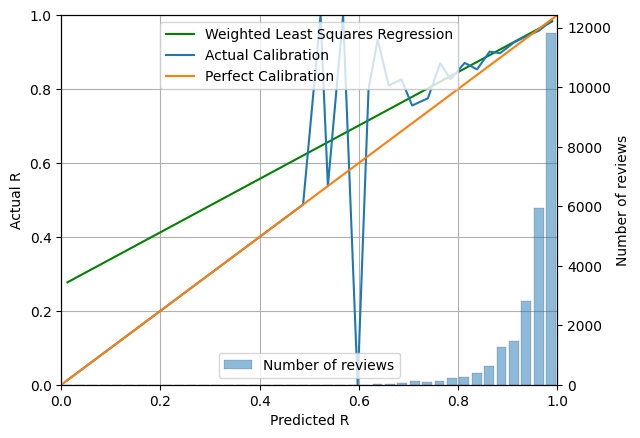

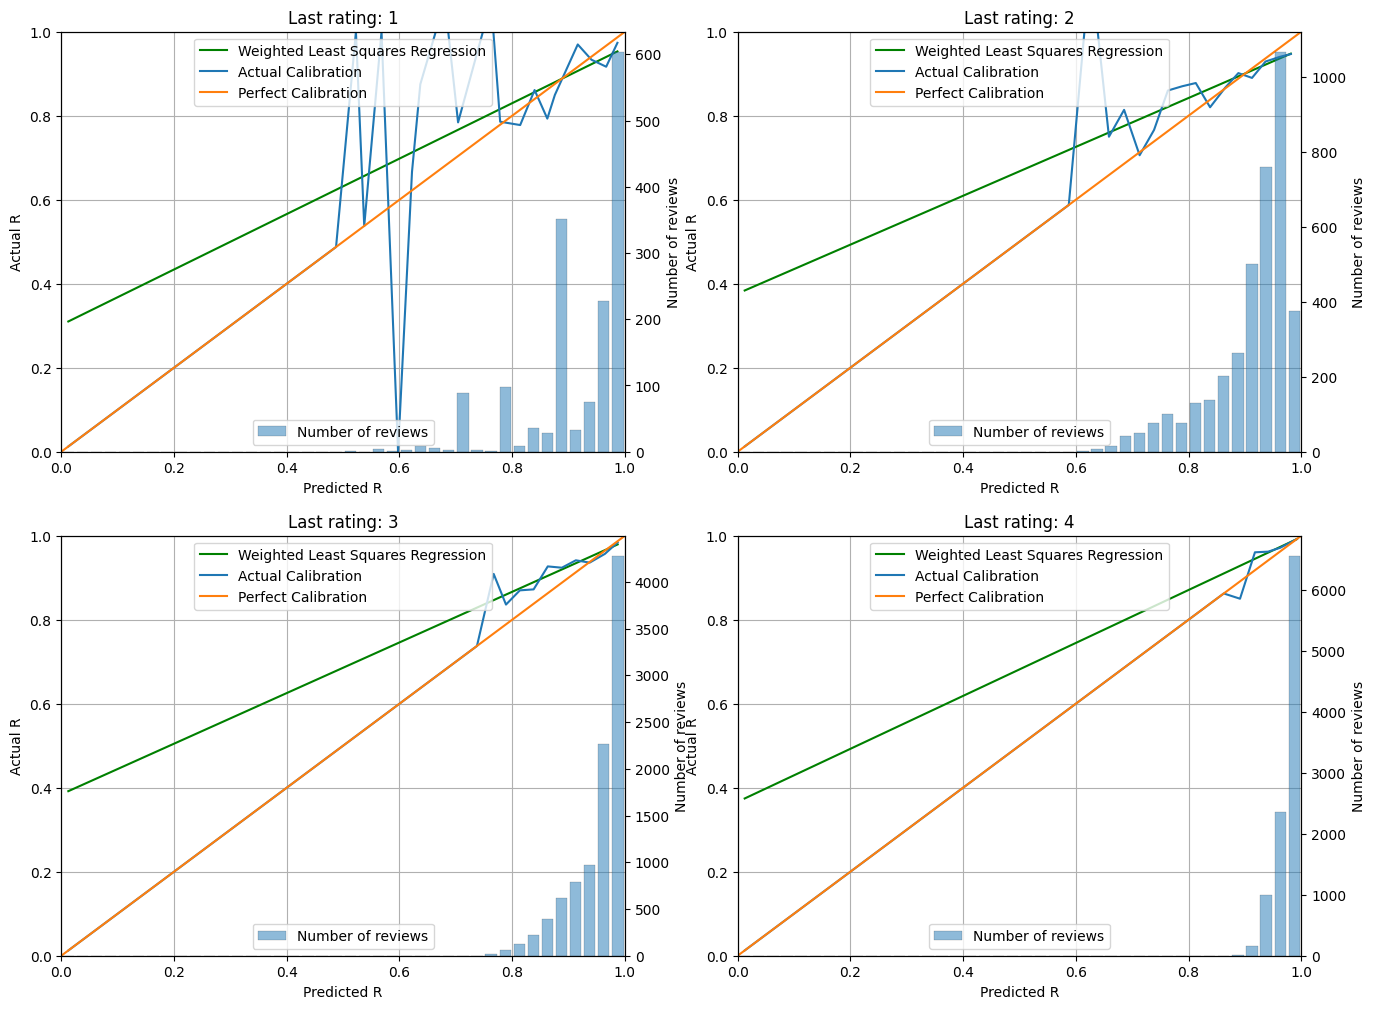

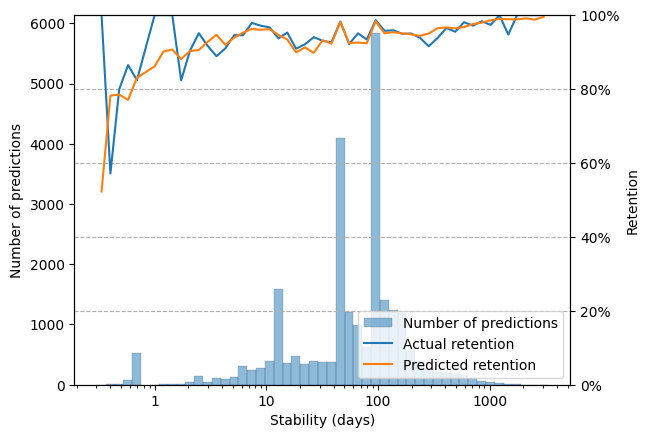

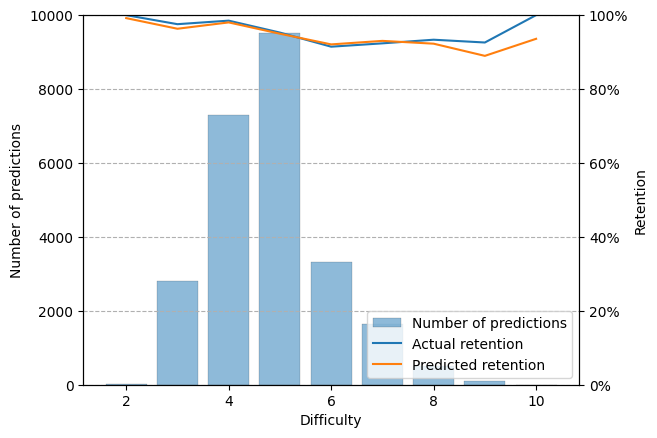

In [17]:
optimizer.calibration_graph()

Loss of SM-2: 0.7038
R-squared: -492.6240
RMSE: 0.4532
MAE: 0.3858
[0.94311185 0.02466251]
Universal Metric of FSRS: 0.0151
Universal Metric of SM2: 0.3900


(<Figure size 640x480 with 2 Axes>, <Figure size 600x600 with 1 Axes>)

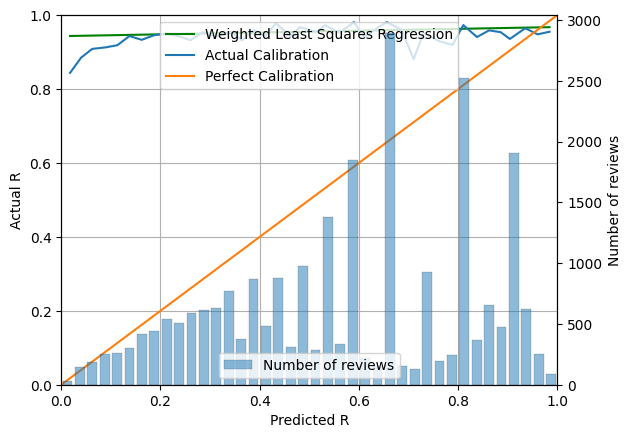

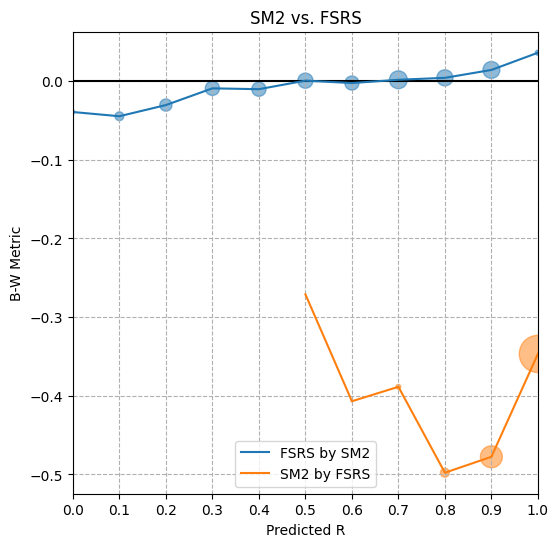

In [18]:
optimizer.compare_with_sm2()

Loss of SM-18: 0.2322
R-squared: -39.9467
RMSE: 0.1454
MAE: 0.0752
[0.84216768 0.12977055]
Universal Metric of FSRS: 0.0219
Universal Metric of SM18: 0.0981


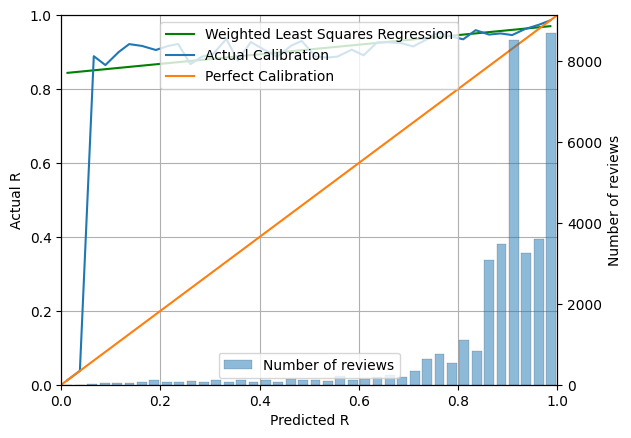

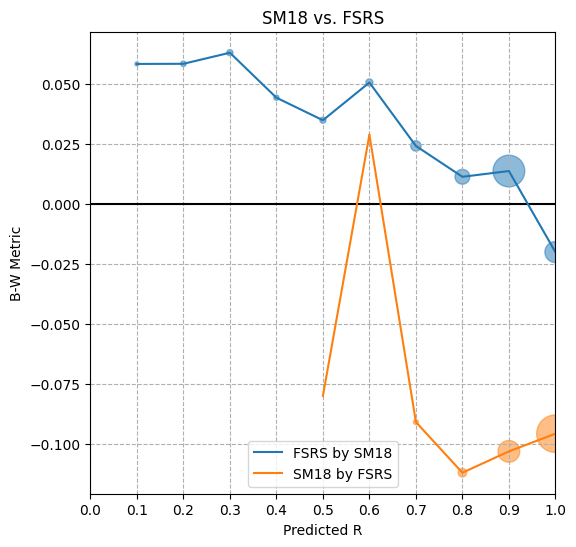

In [19]:
import matplotlib.pyplot as plt
from fsrs_optimizer import plot_brier
from sklearn.metrics import mean_squared_error

revlogs['p'] = optimizer.dataset['p']
revlogs['sm18_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm18_p']) if row['y'] == 1 else - np.log(1 - row['sm18_p']), axis=1)
print(f"Loss of SM-18: {revlogs['log_loss'].mean():.4f}")
cross_comparison = revlogs[['sm18_p', 'p', 'y']].copy()
fig1 = plt.figure()
plot_brier(cross_comparison['sm18_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM18_B-W'] = cross_comparison['sm18_p'] - cross_comparison['y']
cross_comparison['SM18_Bin'] = cross_comparison['sm18_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM18_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
print(f"Universal Metric of FSRS: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False):.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label='FSRS by SM18')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM18_B-W': ['mean'], 'sm18_p': ['mean', 'count']})
print(f"Universal Metric of SM18: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm18_p', 'mean'], sample_weight=cross_comparison_group['sm18_p', 'count'], squared=False):.4f}")
cross_comparison_group['sm18_p', 'percent'] = cross_comparison_group['sm18_p', 'count'] / cross_comparison_group['sm18_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM18_B-W', 'mean'], s=cross_comparison_group['sm18_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM18_B-W', 'mean'], label='SM18 by FSRS')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM18 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))